In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Indian Names.txt


In [2]:
import torch
import torch.nn as nn
import string
import unidecode #making sure everything is in ASCII
import random

In [3]:
file = unidecode.unidecode(open('/kaggle/input/Indian Names.txt').read())

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#gets all ascii characters
all_chars = string.printable
n_chars = len(all_chars)
print(n_chars, all_chars)

100 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [6]:
class NameLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super().__init__()
        #self.input_size = input_size
        self.hidden_size = hidden_size
        #self.output_size = output_size
        self.n_layers = n_layers
        
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, char, hidden, cell):
        out = self.embed(char)
        out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))
        out = self.fc(out.reshape(out.shape[0], -1))
        return out, (hidden, cell)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [15]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_chars.index(string[c])
    return tensor

def get_random_batch():
    start_idx = random.randint(0, len(file)-chunk_len)
    end_idx = start_idx + chunk_len + 1
    text_str = file[start_idx : end_idx]
    text_input = torch.zeros(batch_size, chunk_len)
    text_target = torch.zeros(batch_size, chunk_len)

    for i in range(batch_size):
        text_input[i, :] = char_tensor(text_str[:-1]) 
        text_target[i, :] = char_tensor(text_str[1:]) 

    return text_input.long(), text_target.long()

def generate(initial_str = "A", predict_len = 100, temperature = 0.8):
    hidden, cell = net.init_hidden(batch_size)
    initial_input = char_tensor(initial_str)
    predicted = initial_str

    for p in range(len(initial_str) - 1):
        _, (hidden, cell) = net(initial_input[p].view(1).to(device), hidden, cell)

    last_char = initial_input[-1]

    for p in range(predict_len):
        output, (hidden, cell) = net(last_char.view(1).to(device), hidden, cell)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_char = torch.multinomial(output_dist, 1)[0]
        predicted_char = all_chars[top_char]
        predicted += predicted_char
        last_char = char_tensor(predicted_char)

    return predicted

In [16]:
def time_since(since):
    s = time.time()-since
    m = math.floor(s/60)
    s -= m*60
    return ('%dm %ds' %(m, s))

In [17]:
import time
chunk_len = 150
batch_size = 1
hidden_size = 64
lr = 0.001
n_layers = 2
num_epochs = 3000
print_every = 100

In [18]:
net = NameLSTM(n_chars, hidden_size, n_chars, n_layers).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
print(net)

NameLSTM(
  (embed): Embedding(100, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=100, bias=True)
)


In [19]:
start = time.time()
all_losses = []
loss_avg = 0

print("=> Starting Training")

for epoch in range(1, num_epochs+1):
    inp, target = get_random_batch()
    hidden, cell = net.init_hidden(batch_size)
    
    net.zero_grad()
    loss = 0
    inp = inp.to(device)
    target = target.to(device)
    
    for c in range(chunk_len):
        out, (hidden, cell) = net.forward(inp[:, c], hidden, cell)
        loss += criterion(out, target[:, c])
    
    loss.backward()
    optimizer.step()
    loss = loss.item()/chunk_len
    all_losses.append(loss)
    
    if(epoch % print_every == 0):
        print("Epoch: {}/{}...".format(epoch, num_epochs), "Loss: {:.6f}...".format(loss))
        print(generate())

=> Starting Training
Epoch: 100/3000... Loss: 2.860764...
AYLIAAKAHPENNDDAAATA P
H
ABARLUNO
SIHHOOV
HRGARN
HNITRVNA
ARKI
E 
K
HMSAUIPLNOUSAYIAAAMK
A INLAAA
S
O
Epoch: 200/3000... Loss: 2.863656...
AGU
KINARANNH
ARALIJ
TIIR

KHUSANAPDAMANSASDAID
SASA

AM
THARI
T INHDURNTEAAR
GORHIAMHKAERE
HTRAITSD

Epoch: 300/3000... Loss: 2.568787...
A
VJIHVHASASIGAMA
U
KUMHIN

 BA
B
SHJINIMHUN
NANATHAMHHHIRAN GANANNEN
SANIS


R
BABARHEREKAP
SHERA
HP
Epoch: 400/3000... Loss: 2.394909...
AjVO
SA
AJONIVDA
KAK
LA
SYA TA
DAS
RAEBKJASHA
SHALDHYAMINUKUVETIMEL
ISHUI
HANT
NAMASHIKYHATHASACAMAKE
Epoch: 500/3000... Loss: 2.558388...
AMLOHAL
RA THEGININ
SHAN NADEISUTHRA
GHEDKI VSHIMKETHAN
NAPANJ
LELANTHA
LASHA
RANIBHATAR
RA DAM
THURU
Epoch: 600/3000... Loss: 2.512658...
AM
SEBHIL
KINIBHA
SHWUSHID
OEISH
VASASANSHAL
ROREEP
SHIPET
NANESH
SUGANSHASHA
SENOUTAN
SANANAV
NISHUN
Epoch: 700/3000... Loss: 2.596869...
AT
KARITAT
MATHIMAL
DIRPAM NARSH
RARIPMANT
KANJA
SANSHRUNEDAT
SASINE KAJ
DDITOREDI
KIVRA
RILIL
PANIGA
Epoch:

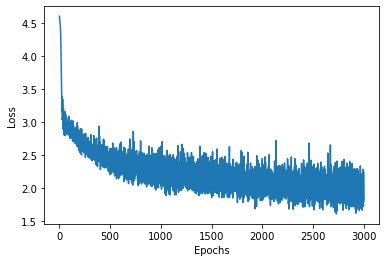

In [21]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
min(all_losses)